# Tests of exponentiating derivative operators

In this notebook we explore the accuracy of derivative operators realized as matrices on a coordinate space mesh and then do tests of exponentiating those operators various ways.

Standard imports plus seaborn (to make plots looks nicer).

In [1]:
import numpy as np
import scipy.linalg as la

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")


We'll define two functions that create matrices that implement approximate derivatives when applied to a vector made up of a function evaluated at the mesh points. The numpy `diag` and `ones` functions are used to create matrices with 1's on particular diagonals, as in these $5\times 5$ examples of forward derivatives: 

$$ \frac{1}{\Delta x}\,\left( 
    \begin{array}{ccccc}
    -1 & 1 & 0 & 0 & 0 \\
    0 & -1 & 1 & 0 & 0 \\
    0 & 0 & -1 & 1 & 0 \\
    0 & 0 &0 & -1 & 1 \\
    0 & 0 & 0 & 0 & -1
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right) 
   \overset{?}{=}
   \left(\begin{array}{c}
         ? \\ ? \\ ? \\ ? \\ ?
         \end{array}
   \right) 
 $$  
 
 and symmetric derivatives:

$$
   \frac{1}{2\Delta x}\,\left( 
    \begin{array}{ccccc}
    0 & 1 & 0 & 0 & 0 \\
    -1 & 0 & 1 & 0 & 0 \\
    0 & -1 & 0 & 1 & 0 \\
    0 & 0 & -1 & 0 & 1 \\
    0 & 0 & 0 & -1 & 0
    \end{array}
   \right) 
   \left(\begin{array}{c}
         f_1 \\ f_2 \\ f_3 \\ f_4 \\ f_5
         \end{array}
   \right)
   \overset{?}{=}
   \left(\begin{array}{c}
         ? \\ ? \\ ? \\ ? \\ ?
         \end{array}
   \right) 
$$
 

In [2]:
def forward_derivative_matrix(N, Delta_x):
    """Return an N x N matrix for derivative of an equally spaced vector by delta_x
    """
    M_temp = np.diag(np.ones(N-1), +1) - np.diag(np.ones(N), 0)
    M_temp[N-1, N-1] = +1
    M_temp[N-1, N-2] = -1
    return M_temp / Delta_x

In [3]:
def symmetric_derivative_matrix(N, Delta_x):
    """Return an Nc x Nc matrix for derivative of an equally spaced vector by delta_x
    """
    M_temp = np.diag(np.ones(N-1), +1) - np.diag(np.ones(N-1), -1)
    M_temp[0, 0] = -2
    M_temp[0, 1] = +2
    M_temp[N-1, N-1] = +2
    M_temp[N-1, N-2] = -2

    return M_temp / (2 * Delta_x)

## Testing forward against symmetric derivative

We'll check the relative accuracy of both approximate derivatives as a function of $\Delta x$ by choosing a test function $f(x)$ and a range of $x$.

In [22]:
N_pts = 201;
x_min = 0.
x_max = 4.
Delta_x = (x_max - x_min) / (N_pts - 1)
x_mesh = np.linspace(x_min, x_max, N_pts)

In [23]:
# Check that mesh is consistent with Delta_x
print(Delta_x)
print(x_mesh)

0.02
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1  2.12 2.14 2.16 2.18 2.2  2.22
 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38 2.4  2.42 2.44 2.46 2.48 2.5
 2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66 2.68 2.7  2.72 2.74 2.76 2.78
 2.8  2.82 2.84 2.86 2.88 2.9  2.92 2.94 2.96 2.98 3.   3.02 3.04 3.06
 3.08 3.1  3.12 3.14 3.16 3.18 3.2  3.22 3.24 3.26 3.28 3.3  3.32 3.34
 3.36 3.38 3.4  3.42 3.44 3.46 3.48 3.5  3.52 3.54 3.56 3.58 3.6  3.62
 3.64 3.66 3.68 3.7  3.72 3.74 3.76 3.78 3.8  3.82 3.84 3.86 3.88 3.9
 3.9

Set up the derivative matrices for the specified mesh.

In [24]:
fd = forward_derivative_matrix(N_pts, Delta_x)
sd = symmetric_derivative_matrix(N_pts, Delta_x)

### Set up various test functions

In [25]:
def f_test_0(x_mesh):
    """
    Return the value of the function x^4 e^{-x} and its derivative
    """
    return ( np.exp(-x_mesh), -np.exp(-x_mesh) )    

def f_test_1(x_mesh):
    """
    Return the value of the function x^4 e^{-x} and its derivative
    """
    return ( np.exp(-x_mesh) * x_mesh**4, (4 * x_mesh**3 - x_mesh**4) * np.exp(-x_mesh) )    

def f_test_2(x_mesh):
    """
    Return the value of the function 1/(1 + x) and its derivative
    """
    return ( 1/(1+x_mesh), -1/(1+x_mesh)**2 )

def f_test_3(x_mesh):
    """
    Return the value of the function 1/(1 + x) and its derivative
    """
    return ( (np.sin(x_mesh))**2, 2 * np.cos(x_mesh) * np.sin(x_mesh) )

Pick one of the test functions and evaluate the function and its derivative on the mesh.
Then apply the forward difference (fd) and symmetric difference (sd) matrices to the `f_test` vector (using the `@` symbol for matrix-vector, matrix-matrix, and vector-vector multiplication).

In [26]:
f_test, f_deriv_exact = f_test_2(x_mesh)

f_deriv_fd = fd @ f_test
f_deriv_sd = sd @ f_test

Make plots comparing the exact to approximate derivative and then the relative errors.

In [27]:
def rel_error(x1, x2):
    """
    Calculate the (absolute value of the) relative error between x1 and x2
    """
    return np.abs( (x1 - x2) / ((x1 + x2)/2) )
    #return np.abs( (x1 - x2)  )


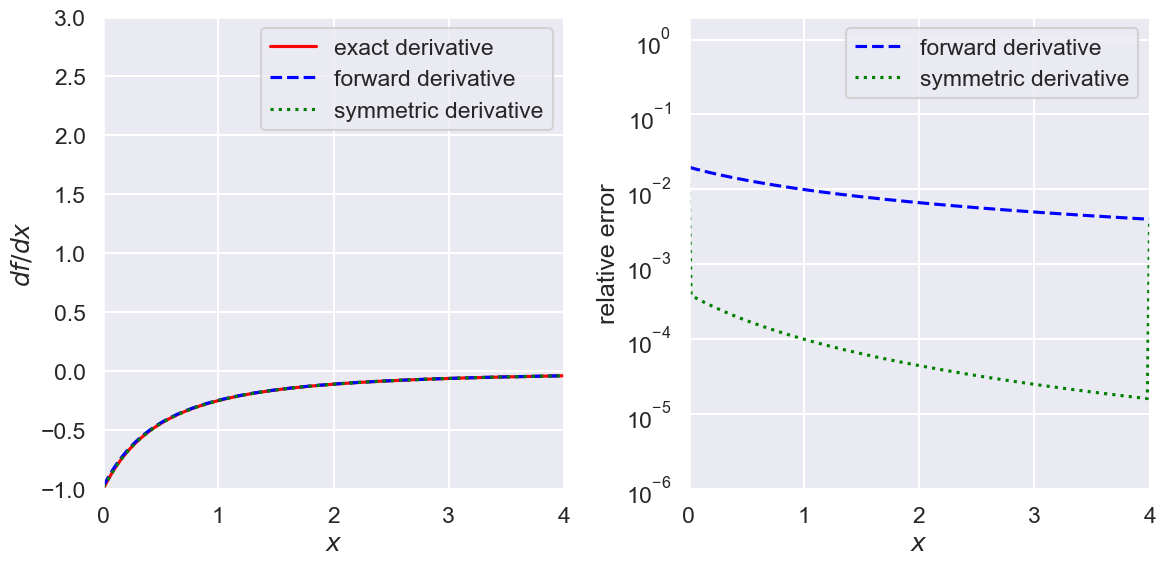

In [28]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$df/dx$')
ax1.set_xlim(0, x_max)
ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_deriv_exact, color='red', label='exact derivative')
ax1.plot(x_mesh, f_deriv_fd, color='blue', label='forward derivative', linestyle='dashed')
ax1.plot(x_mesh, f_deriv_sd, color='green', label='symmetric derivative', linestyle='dotted')

ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
ax2.set_xlim(0, x_max)
ax2.set_ylim(1e-6, 2)

# Calculate relative errors
rel_error_fd = rel_error(f_deriv_exact, f_deriv_fd)
rel_error_sd = rel_error(f_deriv_exact, f_deriv_sd) 

ax2.semilogy(x_mesh, rel_error_fd, color='blue', label='forward derivative', linestyle='dashed')
ax2.semilogy(x_mesh, rel_error_sd, color='green', label='symmetric derivative', linestyle='dotted')
#ax2.loglog(x_mesh, 5e-2 * 1/x_mesh, color='red', linestyle='solid')
#ax2.loglog(x_mesh, 1e-4 * 1/x_mesh**2, color='red', linestyle='solid')

ax2.legend()

fig.tight_layout()

Try a different test function.

**Questions to address:**

1. What specifically goes wrong at the largest value of $x$?
2. Demonstrate by Taylor expansions how much better symmetric derivatives should be than forward derivatives.

## Exponentiating derivative matrices for finite translation

Here we create translation operators in matrix form by exponentiating the derivate matrices.

In [29]:
a = 20 * Delta_x  # translate by a multiple of Delta_x

Below we pick one of the test functions and evaluate the function on the mesh, but displaced by `a` from each `x` point.
Then apply various approximations to an exponentiated derivative, which is an approximation to a translation operator.

The approximations use the forward difference (fd) and symmetric difference (sd) matrices, which in term either use `la.expm`, which is a matrix exponential function, or `la.fractional_matrix_power`, which implements the product approximation.

So we test $e^{M}$ versus $(1 +\frac{M}{N})^N$, where $M$ is the matrix approximation to the derivative operator. 



In [30]:
f_test, f_deriv_exact = f_test_2(x_mesh)
f_exp_exact, dummy  = f_test_2(x_mesh + a)

f_exp_fd = la.expm(a*fd) @ f_test
f_exp_sd = la.expm(a*sd) @ f_test

f_exp_fd2 = la.fractional_matrix_power(np.eye(N_pts) + Delta_x*fd, a/Delta_x) @ f_test
f_exp_sd2 = la.fractional_matrix_power(np.eye(N_pts) + Delta_x*sd, a/Delta_x) @ f_test

First make a comparison plot of exact to matrix exponentiation of either forward derivatives or symmetric derivatives.

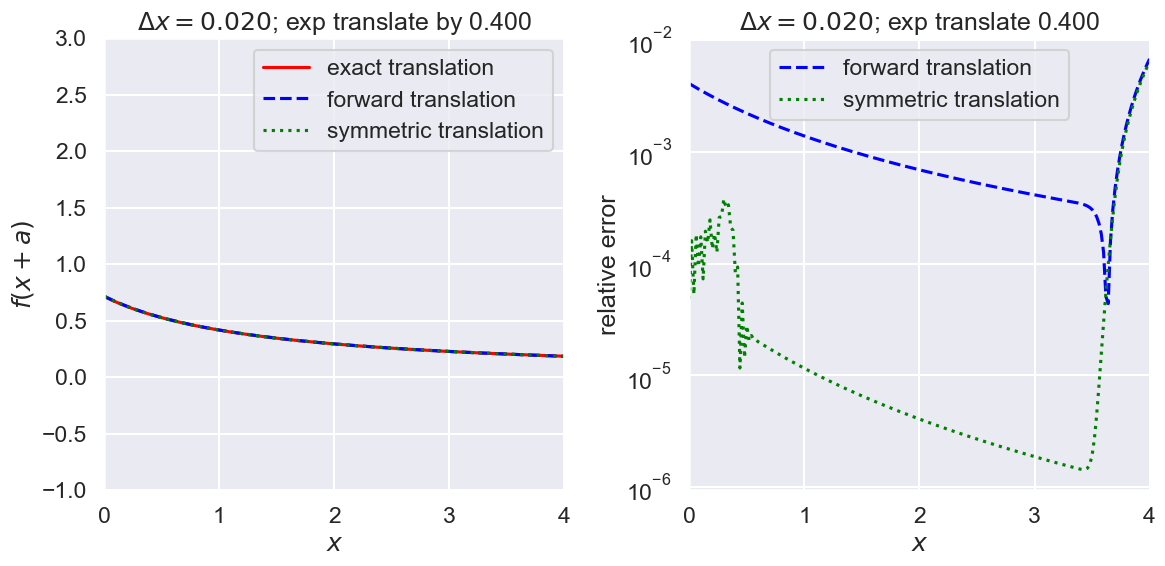

In [31]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$f(x+a)$')
ax1.set_xlim(0, x_max)
ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_exp_exact, color='red', label='exact translation')
ax1.plot(x_mesh, f_exp_fd, color='blue', label='forward translation', linestyle='dashed')
ax1.plot(x_mesh, f_exp_sd, color='green', label='symmetric translation', linestyle='dotted')

ax1.set_title(fr'$\Delta x = {Delta_x:.3f}$; exp translate by {a:.3f}')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
ax2.set_xlim(0, x_max)
#ax2.set_ylim(-0.001, 0.001)

rel_error_fd = rel_error(f_exp_exact, f_exp_fd)
rel_error_sd = rel_error(f_exp_exact, f_exp_sd) 

ax2.semilogy(x_mesh, rel_error_fd, color='blue', label='forward translation', linestyle='dashed')
ax2.semilogy(x_mesh, rel_error_sd, color='green', label='symmetric translation', linestyle='dotted')

ax2.set_title(fr'$\Delta x = {Delta_x:.3f}$; exp translate {a:.3f}')
ax2.legend()

fig.tight_layout()

Now make a comparison plot of exact to power translation with either forward derivatives or symmetric derivatives.

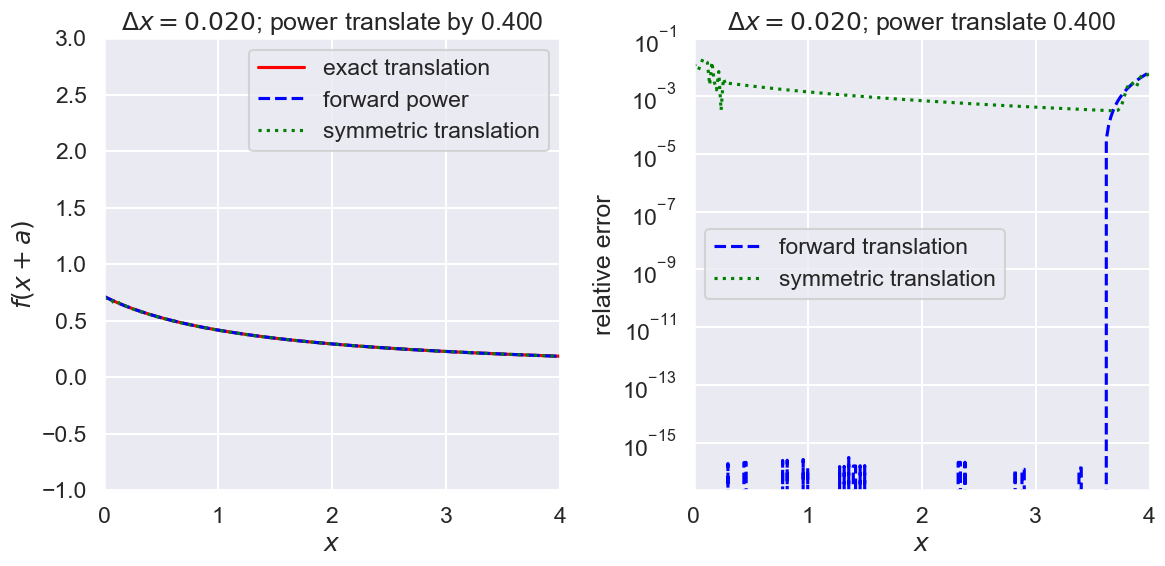

In [32]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$f(x+a)$')
ax1.set_xlim(0, x_max)
ax1.set_ylim(-1., 3)

ax1.plot(x_mesh, f_exp_exact, color='red', label='exact translation')
ax1.plot(x_mesh, f_exp_fd2, color='blue', label='forward power', linestyle='dashed')
ax1.plot(x_mesh, f_exp_sd2, color='green', label='symmetric translation', linestyle='dotted')

ax1.set_title(fr'$\Delta x = {Delta_x:.3f}$; power translate by {a:.3f}')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'relative error')
ax2.set_xlim(0, x_max)

rel_error_fd = rel_error(f_exp_exact, f_exp_fd2)
rel_error_sd = rel_error(f_exp_exact, f_exp_sd2) 

ax2.semilogy(x_mesh, rel_error_fd, color='blue', label='forward translation', linestyle='dashed')
ax2.semilogy(x_mesh, rel_error_sd, color='green', label='symmetric translation', linestyle='dotted')

ax2.set_title(fr'$\Delta x = {Delta_x:.3f}$; power translate {a:.3f}')
ax2.legend()

fig.tight_layout()